In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import json
import torch

sns.set(context="paper", style="whitegrid", font_scale=1.5)
%matplotlib inline

In [2]:
exp_name = "200904_mnist"
use_eval_runs = True

In [3]:
files_train = f"../results/{exp_name}/*/config.json"
files_eval = f"../results/{exp_name}/*/eval/*/config.json"

if use_eval_runs:
    files = files_eval
else:
    files = files_train

In [4]:
def plot_grid(runs, y, yerr=None, ylabel="performance", ylim=None):
    scales = sorted(runs.weight_scale.unique())
    temps = sorted(runs.temperature.unique())
    fig, axes = plt.subplots(len(scales), len(temps), sharex=True, sharey=True, figsize=(10,10))

    for scale, axs in zip(scales, axes):
        for temp, ax in zip(temps, axs):
            df = runs.sort_values(["weight_prior", "weight_scale"]).query(f"weight_scale == {scale} & temperature == {temp}")
            df.plot(x="weight_prior", y=y, yerr=yerr, kind="bar", legend=False, ax=ax)
            ax.set_title(f"scale={scale} and T={temp}")
            ax.set_ylabel(ylabel)
            if ylim is not None:
                ax.set_ylim(ylim)

    fig.tight_layout()
    return fig

In [5]:
runs = []
for config_file in glob(files):
    with open(config_file) as infile:
        config = pd.Series(json.load(infile))
    with open(config_file[:-11] + "run.json") as infile:
        result = pd.Series(json.load(infile)["result"], dtype=np.float32)
    if config["weight_prior"] == "improper" and config["weight_scale"] == 1.41 and config["temperature"] == 1.0:
        print(os.path.dirname(config_file))
    run_data = pd.concat([config, result])
    runs.append(run_data)
runs_all = pd.concat(runs, axis=1).T

../results/200904_mnist/51/eval/1


In [6]:
runs_all["error_mean"] = 1. - runs_all["acc_mean"]

In [7]:
runs_all.head()

,accuracy_eval,batch_size,batchnorm,bias_loc,bias_prior,bias_prior_params,bias_scale,burnin,calibration_eval,config_file,...,weight_scale,width,acc_mean,acc_std,acc_stderr,lp_mean,lp_std,lp_stderr,simple_marglik,error_mean
0,True,64,True,0,gaussian,{},1,10,False,../results/200904_mnist/21/config.json,...,0.7,100,0.972466,0.00130378,0.000130378,-0.0757862,0.3253,0.00325299,-1.40421e+06,0.027534
1,True,64,True,0,gaussian,{},1,10,False,../results/200904_mnist/84/config.json,...,1.41,100,0.359991,0.258085,0.0258085,-1.5064,0.421688,0.00421688,-8.30361e+08,0.640009
2,True,64,True,0,gaussian,{},1,10,False,../results/200904_mnist/87/config.json,...,1.41,100,0.232712,0.221504,0.0221504,-1.85712,0.230871,0.00230871,-1.13411e+09,0.767288
3,True,64,True,0,gaussian,{},1,10,False,../results/200904_mnist/69/config.json,...,1.41,100,0.157126,0.18771,0.018771,-1.94701,0.0731617,0.000731617,-1.23227e+12,0.842874
4,True,64,True,0,gaussian,{},1,10,False,../results/200904_mnist/67/config.json,...,1.41,100,0.1135,1.11582e-16,1.11582e-17,-2.30102,0.0536103,0.000536103,-1.61836e+06,0.8865


In [8]:
if use_eval_runs:
    runs_selected = runs_all.query("eval_data != eval_data")  # basically checks for None
else:
    runs_selected = runs_all

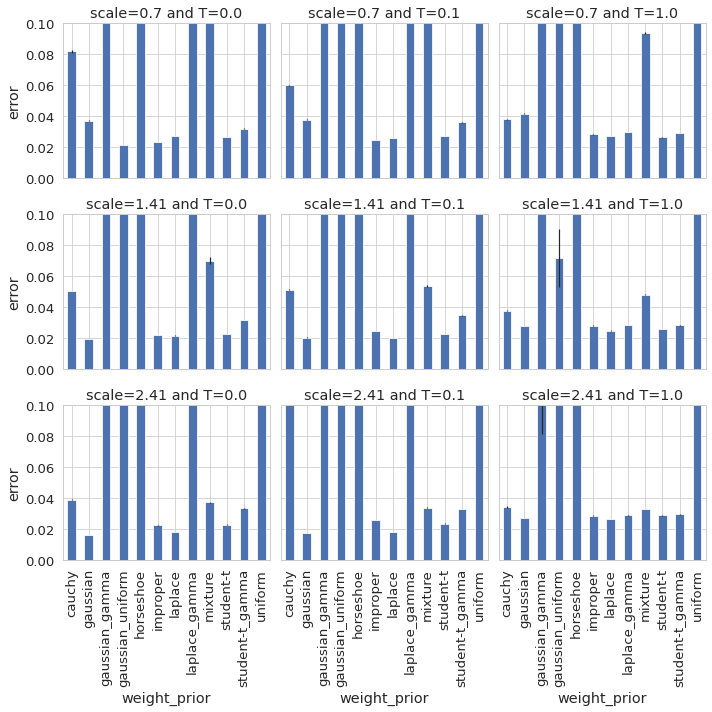

In [9]:
fig = plot_grid(runs_selected, y="error_mean", yerr="acc_stderr", ylabel="error", ylim=(0, 0.1))

In [10]:
fig.savefig(f"../figures/{exp_name}_acc.pdf")

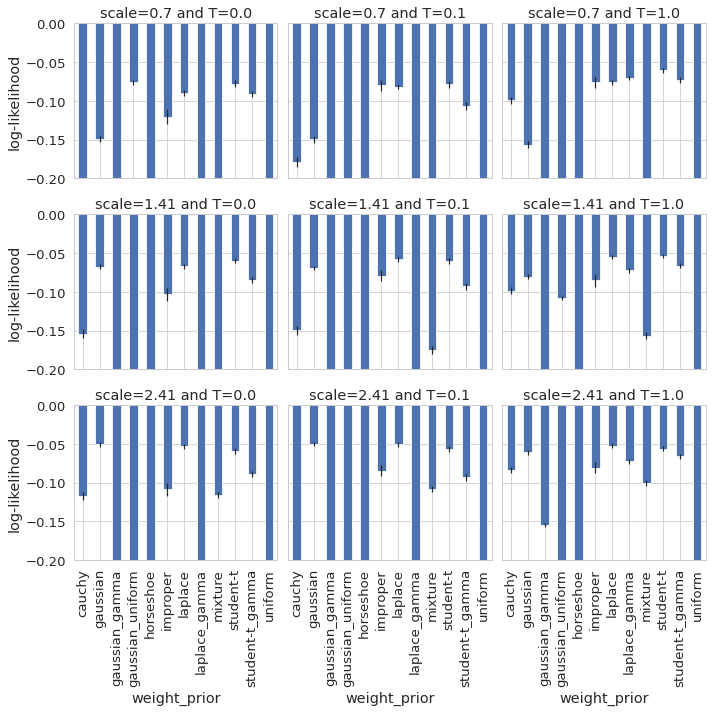

In [11]:
fig = plot_grid(runs_selected, y="lp_mean", yerr="lp_stderr", ylabel="log-likelihood", ylim=(-0.2, 0))

In [12]:
fig.savefig(f"../figures/{exp_name}_ll.pdf")

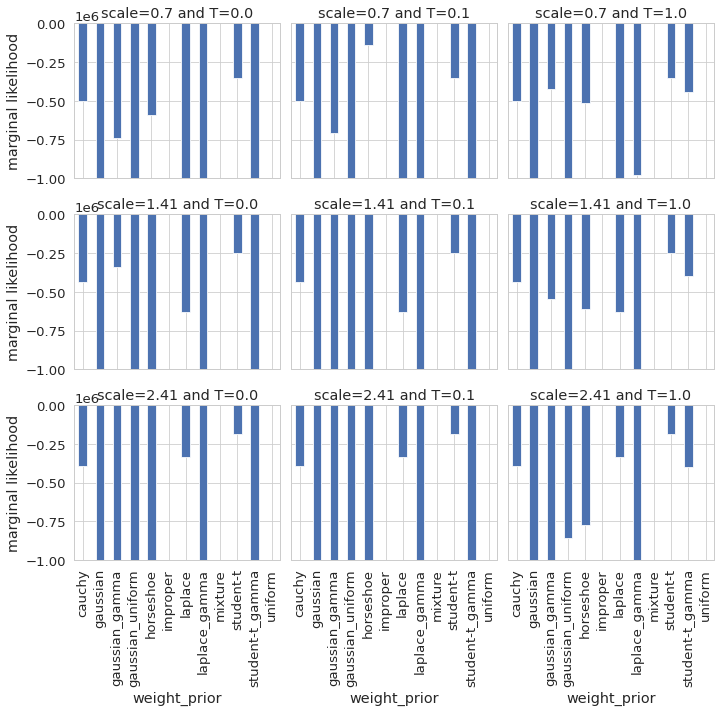

In [16]:
fig = plot_grid(runs_selected, y="simple_marglik", ylabel="marginal likelihood", ylim=(-1e6, 1e2))

In [17]:
fig.savefig(f"../figures/{exp_name}_marglik.pdf")

In [21]:
runs_selected.corr()

""


In [18]:
components = ["gaussian", "laplace", "student-t", "cauchy"]

for config_file in glob(files_train):
    with open(config_file) as infile:
        config = pd.Series(json.load(infile))
    if config["weight_prior"] == "mixture":
        samples = torch.load(os.path.join(os.path.dirname(config_file),"samples.pt"))
        mixture_weights = {k[:5]:torch.nn.functional.softmax(v[-1], dim=0).detach().numpy()
                   for k, v in samples.items() if "mixture_weights" in k}
        print(f"scale = {config['weight_scale']}, T = {config['temperature']}")
        for layer, weights in mixture_weights.items():
            order = np.argsort(weights)[::-1]
            print(f"{layer}: ", " + ".join([f"{weights[i]:.3f} * {components[i]}" for i in order]))

scale = 1.41, T = 0.0
net.0:  1.000 * laplace + 0.000 * gaussian + 0.000 * student-t + 0.000 * cauchy
net.2:  1.000 * laplace + 0.000 * gaussian + 0.000 * student-t + 0.000 * cauchy
net.4:  0.997 * laplace + 0.001 * student-t + 0.001 * cauchy + 0.000 * gaussian
scale = 1.41, T = 0.1
net.0:  1.000 * laplace + 0.000 * gaussian + 0.000 * student-t + 0.000 * cauchy
net.2:  1.000 * laplace + 0.000 * student-t + 0.000 * gaussian + 0.000 * cauchy
net.4:  0.996 * laplace + 0.002 * student-t + 0.001 * cauchy + 0.000 * gaussian
scale = 0.7, T = 0.0
net.0:  1.000 * laplace + 0.000 * gaussian + 0.000 * student-t + 0.000 * cauchy
net.2:  1.000 * laplace + 0.000 * student-t + 0.000 * gaussian + 0.000 * cauchy
net.4:  0.996 * laplace + 0.002 * student-t + 0.002 * cauchy + 0.000 * gaussian
scale = 2.41, T = 1.0
net.0:  1.000 * laplace + 0.000 * gaussian + 0.000 * student-t + 0.000 * cauchy
net.2:  0.999 * laplace + 0.001 * gaussian + 0.000 * student-t + 0.000 * cauchy
net.4:  0.992 * laplace + 0.005 *

In [13]:
assert use_eval_runs, "The calibration and OOD can only be assessed on eval data"

AssertionError: The calibration and OOD can only be assessed on eval data

In [ ]:
runs_selected = runs_all.query("eval_data == 'rotated_mnist'")

In [ ]:
fig = plot_grid(runs_selected, y="rmsce", ylabel="RMSCE", ylim=(0, 0.015))

In [ ]:
fig.savefig(f"../figures/{exp_name}_rmsce.pdf")

In [ ]:
runs_selected = runs_all.query("eval_data == 'fashion_mnist'")

In [ ]:
fig = plot_grid(runs_selected, y="auroc_mean", yerr="auroc_stderr", ylabel="OOD AUROC", ylim=(0.5, 1.))

In [ ]:
fig.savefig(f"../figures/{exp_name}_ood.pdf")